# Tutorial: SP1 bindings in Cre-driver mouse lines. 

 This is a transcription factor SP1 binding bulk calling cards data in cre-driver mouseline and bulk brd4 data is also sequenced as backgound. This data contain two time points: day 10(P10) and day 28(P28). The data are from [Cammack et al., PNAS. (2020)](https://www.pnas.org/doi/10.1073/pnas.1918241117) and could be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE128493).
 
 
 In this tutorial, we will call peaks, make annotation, do differential peak analysis. There are 271946 insertions in P10 ccf file, 1083099 insertions in P28 ccf file, and 5573110 insertions in brd4 ccf file.

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc

We start by reading ccf data. In this data, one row is one insertion and columns indecate the chromosome, start point and end point, read number, direction and borcode of each insertion. For example, the first row means one insertion is on Chromosome 1 and starts from 3095378 to 3095382. The read number is 7 with direction from 3' to 5'. The barcode of the cell is TAAGG. We give it the group column to distinguish between groups. 

You could use ```cc.rd.read_ccf(filename)``` to read your own ccf data.

In [2]:
SP1_P10 = cc.datasets.SP1_Cre_data(data="SP1_P10")
SP1_P10['group'] = 'P10'
SP1_P10

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3095378,3095382,7,+,TAAGG,P10
1,chr1,3120128,3120132,1,+,GTTAC,P10
2,chr1,3121275,3121279,10,-,GTTAC,P10
3,chr1,3121275,3121279,2,-,GTTAC,P10
4,chr1,3222947,3222951,1,-,GTTAC,P10
...,...,...,...,...,...,...,...
271941,chrY,1010004,1010008,1,-,GTTAC,P10
271942,chrY,1011155,1011159,12,-,GTTAC,P10
271943,chrY,1178766,1178770,10,+,GTTAC,P10
271944,chrY,1244787,1244791,11,+,GTTAC,P10


In [3]:
SP1_P28 = cc.datasets.SP1_Cre_data(data="SP1_P28")
SP1_P28['group'] = 'P28'
SP1_P28

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3071865,3071869,76,+,GTCAT,P28
1,chr1,3095378,3095382,7,+,ACTGC,P28
2,chr1,3102707,3102711,1,-,GTCAT,P28
3,chr1,3119905,3119909,4,+,GTCAT,P28
4,chr1,3120189,3120193,66,-,GTCAT,P28
...,...,...,...,...,...,...,...
1083094,chrY,90803579,90803583,14,-,GTCAT,P28
1083095,chrY,90805130,90805134,10,+,ACTGC,P28
1083096,chrY,90805130,90805134,1,+,CGAAA,P28
1083097,chrY,90806531,90806535,5,-,GTCAT,P28


In order to call peak, we need to conbine two ccf files together.

In [4]:
SP1 = cc.rd.combine_ccf([SP1_P10,SP1_P28])
SP1

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3071865,3071869,76,+,GTCAT,P28
1,chr1,3095378,3095382,7,+,TAAGG,P10
2,chr1,3095378,3095382,7,+,ACTGC,P28
3,chr1,3102707,3102711,1,-,GTCAT,P28
4,chr1,3119905,3119909,4,+,GTCAT,P28
...,...,...,...,...,...,...,...
1355040,chrY,90803579,90803583,14,-,GTCAT,P28
1355041,chrY,90805130,90805134,10,+,ACTGC,P28
1355042,chrY,90805130,90805134,1,+,CGAAA,P28
1355043,chrY,90806531,90806535,5,-,GTCAT,P28


We then read the brd4 background file.

In [5]:
bg = cc.datasets.SP1_Cre_data(data="background")
bg

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,3004272,3004276,5,+,ACTGC
1,chr1,3028063,3028067,6,-,ACTGC
2,chr1,3043241,3043245,1,-,ACTGC
3,chr1,3049117,3049121,1,-,CAGTG
4,chr1,3052152,3052156,1,+,ACTGC
...,...,...,...,...,...,...
5573105,chrY,90811001,90811005,2,+,CAGTG
5573106,chrY,90811001,90811005,1,+,CAGTG
5573107,chrY,90811001,90811005,1,+,CAGTG
5573108,chrY,90811001,90811005,2,+,TGACA


Because the insertions are discrete, we now call the peaks to diagnose potential binding sites. Three different methods ('CCcaller','ccf_tools','Blockify') are available along with there different species (’hg38‘,'mm10','yeast'). 

In this setting, we use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*, it would control the maximum distace bwtween two nearby insertions, in another word, that is the minimun distance between two peaks. 1500-2500 is a good parameter for *maxbetween*.  *pvalue_cutoffTTAA* and *pvalue_cutoffTTAA* are also important parameters and the numbers below 0.1 is strongly adviced. Normally, *pvalue_cutoffbg* should be lower than *pvalue_cutoffTTAA*.

In [6]:
peak_data = cc.pp.callpeaks(SP1, bg,  method = "CCcaller", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 1800,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peak.bed")
peak_data

For the CCcaller method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 29/29 [01:19<00:00,  2.74s/it]


,Chr,Start,End,Experiment Insertions,Background insertions,Reference Insertions,Expected Insertions background,Expected Insertions Reference,pvalue Background,pvalue Reference
0,chr1,3119705,3121479,5,11,12,2.449215,1.019967,3.871438e-02,6.578874e-04
1,chr1,3492726,3493906,6,14,9,3.089910,0.789975,3.824654e-02,1.915941e-05
2,chr1,3672013,3673194,61,47,9,10.137554,0.789975,0.000000e+00,0.000000e+00
3,chr1,4773450,4774237,6,5,4,1.167825,0.406656,2.134275e-04,2.559005e-07
4,chr1,4785206,4786670,31,47,13,10.137554,1.096631,3.342206e-08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
23573,chrY,896958,898518,6,4,12,1.104831,0.102376,1.528281e-04,2.138312e-11
23574,chrY,1009804,1011443,17,2,16,0.602415,0.103168,0.000000e+00,0.000000e+00
23575,chrY,1244073,1246463,6,9,21,2.360870,0.104157,1.067924e-02,2.409062e-11
23576,chrY,1286004,1286939,6,5,11,1.356039,0.102178,5.168551e-04,2.109901e-11


The above approach is first combine the data and then call peaks together. Although not recommended, you could also try call peaks seperately and then merge the peaks by [pybedtools](https://daler.github.io/pybedtools/). Below are the codes:

```python
import pybedtools
peak_data1 = cc.pp.callpeaks(SP1_P10, bg,  method = "CCcaller", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 1800,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = None,  pseudocounts = 0.1, record = True)
peak_data2 = cc.pp.callpeaks(SP1_P28, bg,  method = "CCcaller", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 1800,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = None,  pseudocounts = 0.1, record = True)
peak = cc.rd.combine_ccf([peak_data1,peak_data2])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})

```

In order to choose suitable method and parameters for peak calling, please take a look at genome areas. We stongly advice to adjust the parameters for ```cc.pp.callpeaks()``` to call better peaks.

In this plot, the colored ones are the experiment ccf data and the gray ones are the background data. The first part is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The second part is the distribution of insertions. The third part represents reference genes and peaks. 


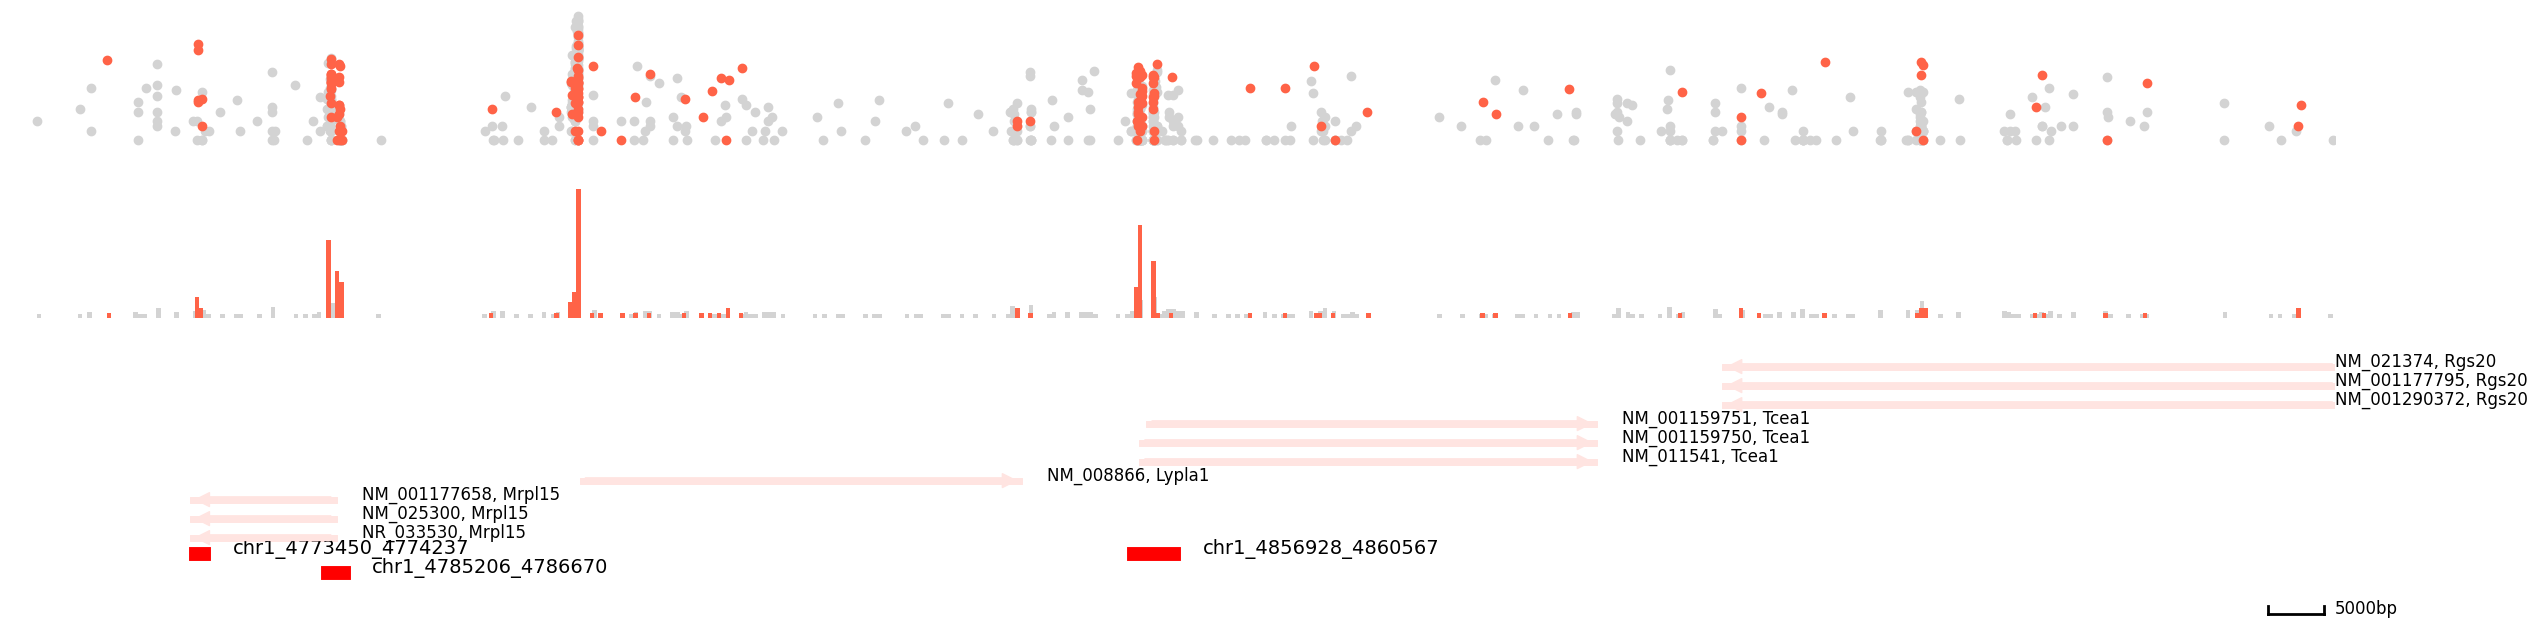

In [7]:
cc.pl.draw_area("chr1",4856929,4863861,100000,peak_data, SP1, "mm10", bg,
                figsize = (30,8),peak_line = 2,save = False, bins = 500, example_length = 5000)

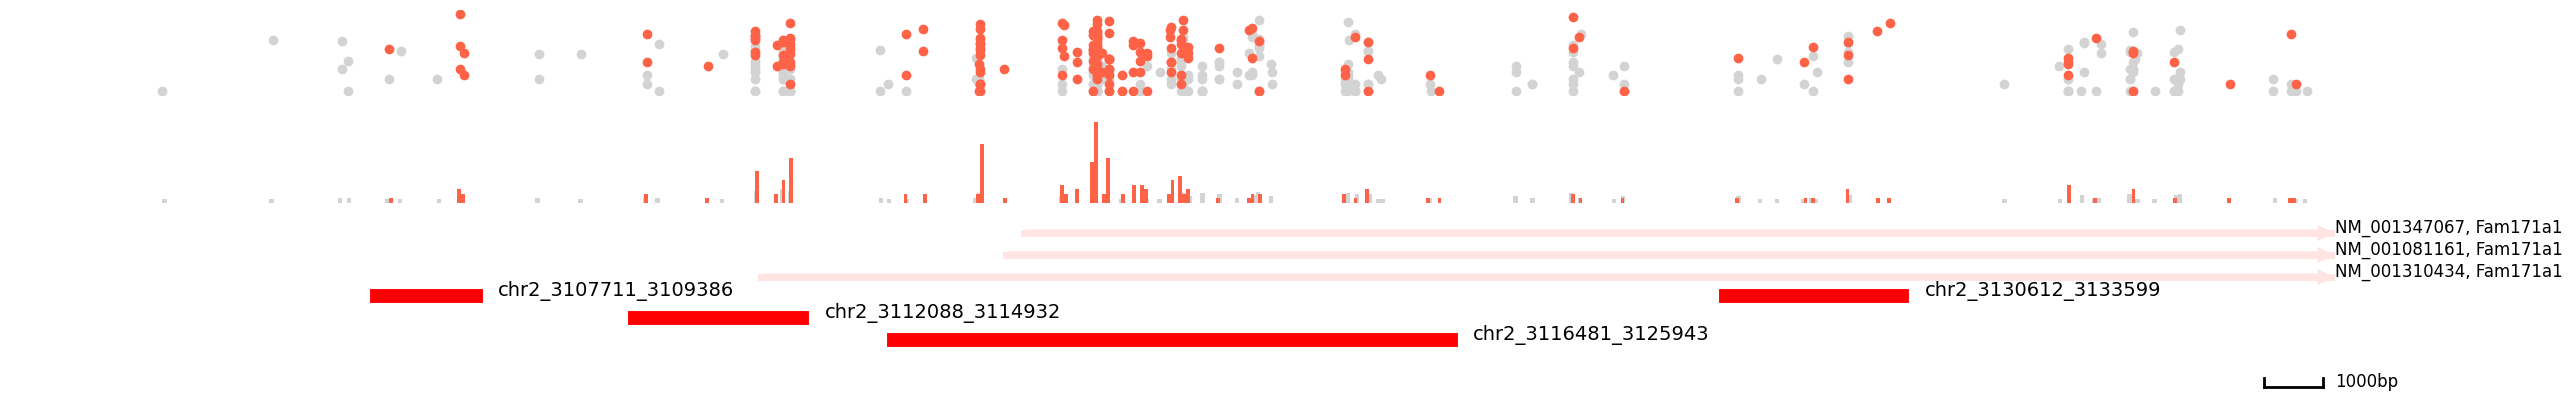

In [8]:
cc.pl.draw_area("chr2",3116481,3125943,15000,peak_data, SP1, "mm10", bg,
                figsize = (30,5),peak_line = 3,save = False, bins = 500, example_length = 1000)

We advice to look at the whole chromosome and see the distribution of peaks to make sure everything is going right.

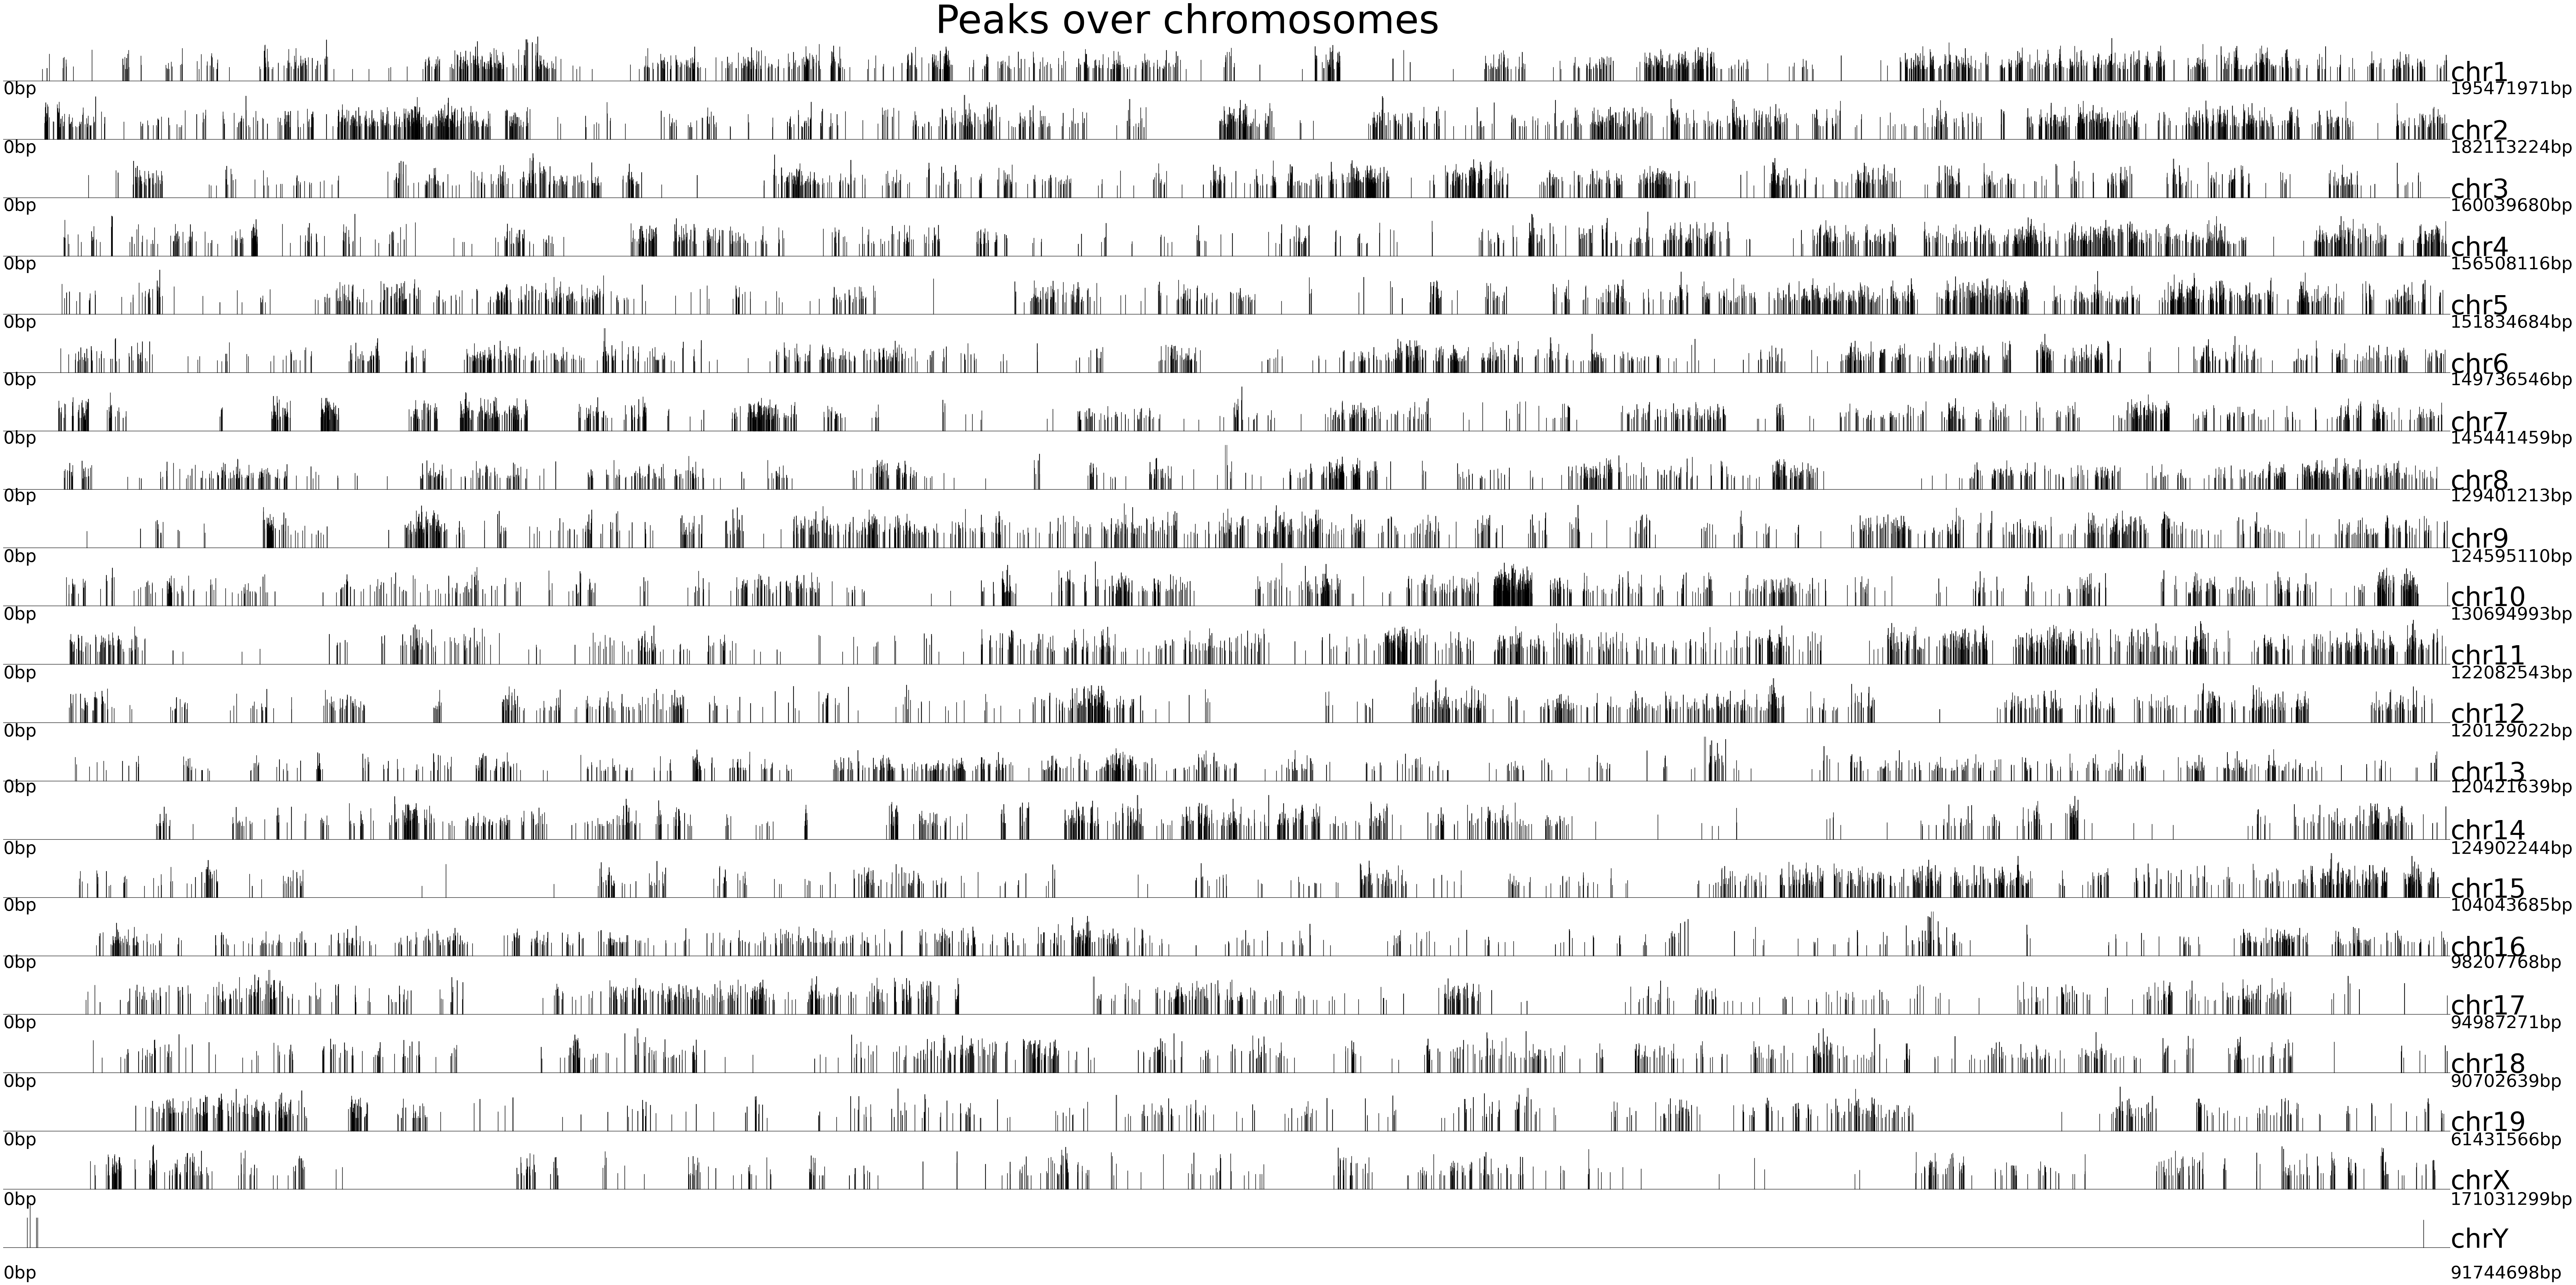

In [9]:
cc.pl.whole_peaks(peak_data,linewidth = 1, reference = "mm10")

In the next step, we annotate the peaks by their closest genes using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [10]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Experiment Insertions,Background insertions,Reference Insertions,Expected Insertions background,Expected Insertions Reference,pvalue Background,pvalue Reference,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,3119705,3121479,5,11,12,2.449215,1.019967,3.871438e-02,6.578874e-04,NM_001011874,Xkr4,NM_001195662,Rp1
1,chr1,3492726,3493906,6,14,9,3.089910,0.789975,3.824654e-02,1.915941e-05,NM_001011874,Xkr4,NM_001195662,Rp1
2,chr1,3672013,3673194,61,47,9,10.137554,0.789975,0.000000e+00,0.000000e+00,NM_001011874,Xkr4,NM_001195662,Rp1
3,chr1,4773450,4774237,6,5,4,1.167825,0.406656,2.134275e-04,2.559005e-07,NR_033530,Mrpl15,NM_008866,Lypla1
4,chr1,4785206,4786670,31,47,13,10.137554,1.096631,3.342206e-08,0.000000e+00,NR_033530,Mrpl15,NM_008866,Lypla1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23573,chrY,896958,898518,6,4,12,1.104831,0.102376,1.528281e-04,2.138312e-11,NM_011419,Kdm5d,NM_011667,Uba1y
23574,chrY,1009804,1011443,17,2,16,0.602415,0.103168,0.000000e+00,0.000000e+00,NM_012011,Eif2s3y,NR_027507,Tspy-ps
23575,chrY,1244073,1246463,6,9,21,2.360870,0.104157,1.067924e-02,2.409062e-11,NM_009484,Uty,NM_012008,Ddx3y
23576,chrY,1286004,1286939,6,5,11,1.356039,0.102178,5.168551e-04,2.109901e-11,NM_012008,Ddx3y,NM_148943,Usp9y


Use ccf data, peak data and group names to make a group by peak anndata object.

In [11]:
adata_ccf = cc.pp.makeAnndata(SP1, peak_annotation, ["P10", "P28"], key = 'group')
adata_ccf

AnnData object with n_obs × n_vars = 2 × 23578
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Background insertions', 'Reference Insertions', 'Expected Insertions background', 'Expected Insertions Reference', 'pvalue Background', 'pvalue Reference', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Filter peaks by minimum count.

In [12]:
cc.pp.filter_peaks(adata_ccf, min_counts=5)
adata_ccf

AnnData object with n_obs × n_vars = 2 × 23578
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Background insertions', 'Reference Insertions', 'Expected Insertions background', 'Expected Insertions Reference', 'pvalue Background', 'pvalue Reference', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'n_counts'

Differential peak analysis would find out the significant binding for each group. In this example, we use *fisher exact test* to find out.

In [13]:
cc.tl.rank_peak_groups(adata_ccf,"Index",method = 'fisher_exact',key_added = 'fisher_exact')

Plot the results for differential peak analysis.

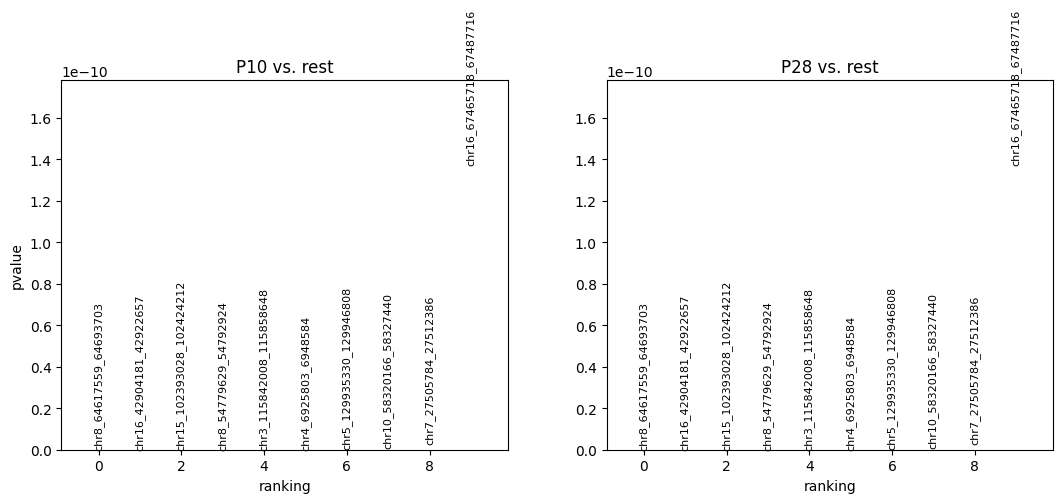

In [14]:
cc.pl.rank_peak_groups(adata_ccf, key = 'fisher_exact')

Then, we take a look at the genome for highly differentiated peaks. The colored ones are the insertions for specific cluster and the grey ones are the backgound insertions information. If we don't input the backgound file, the grey ones would be the total insertions.

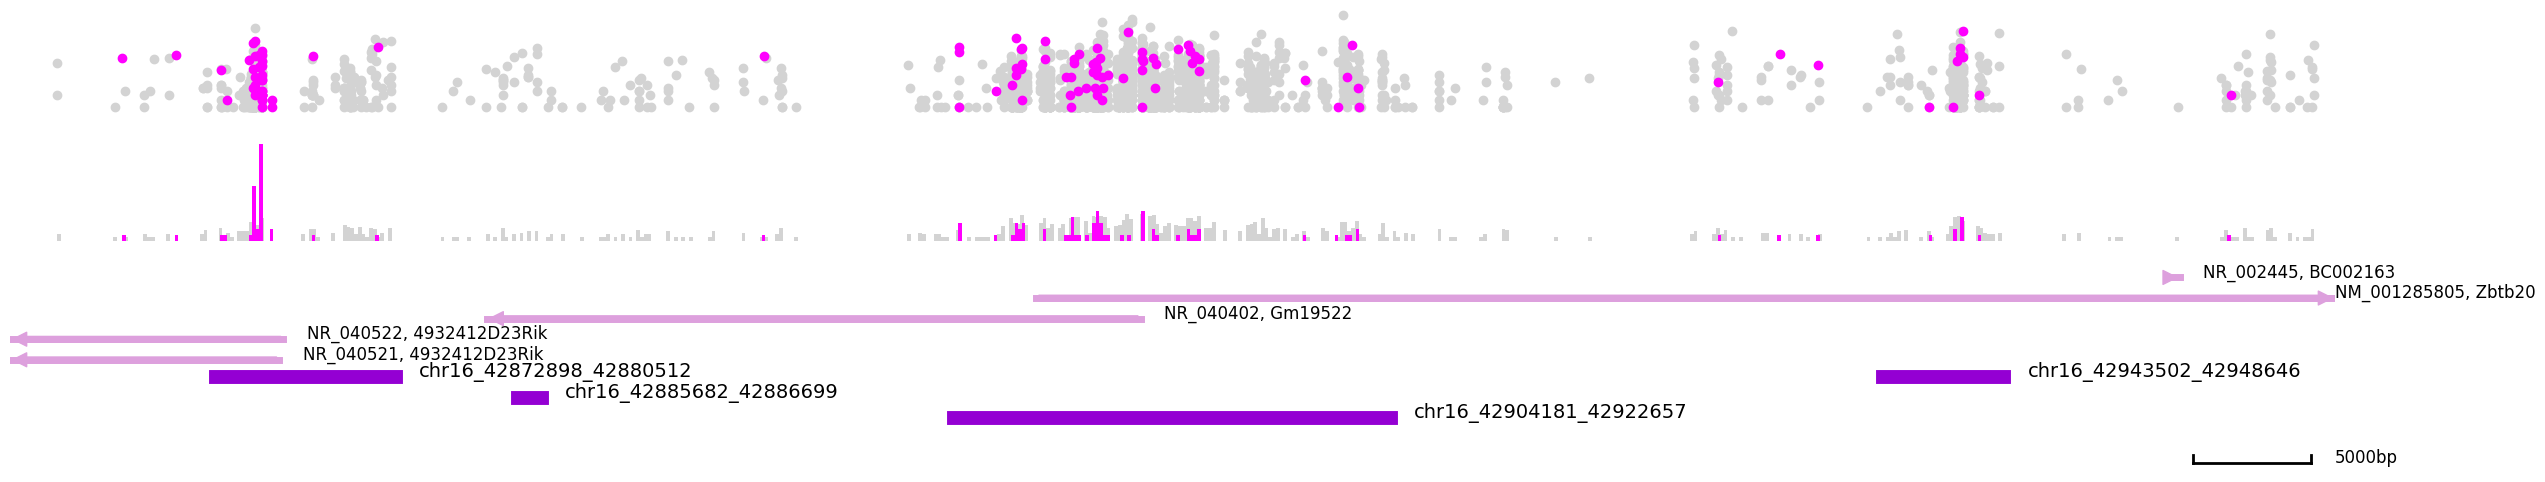

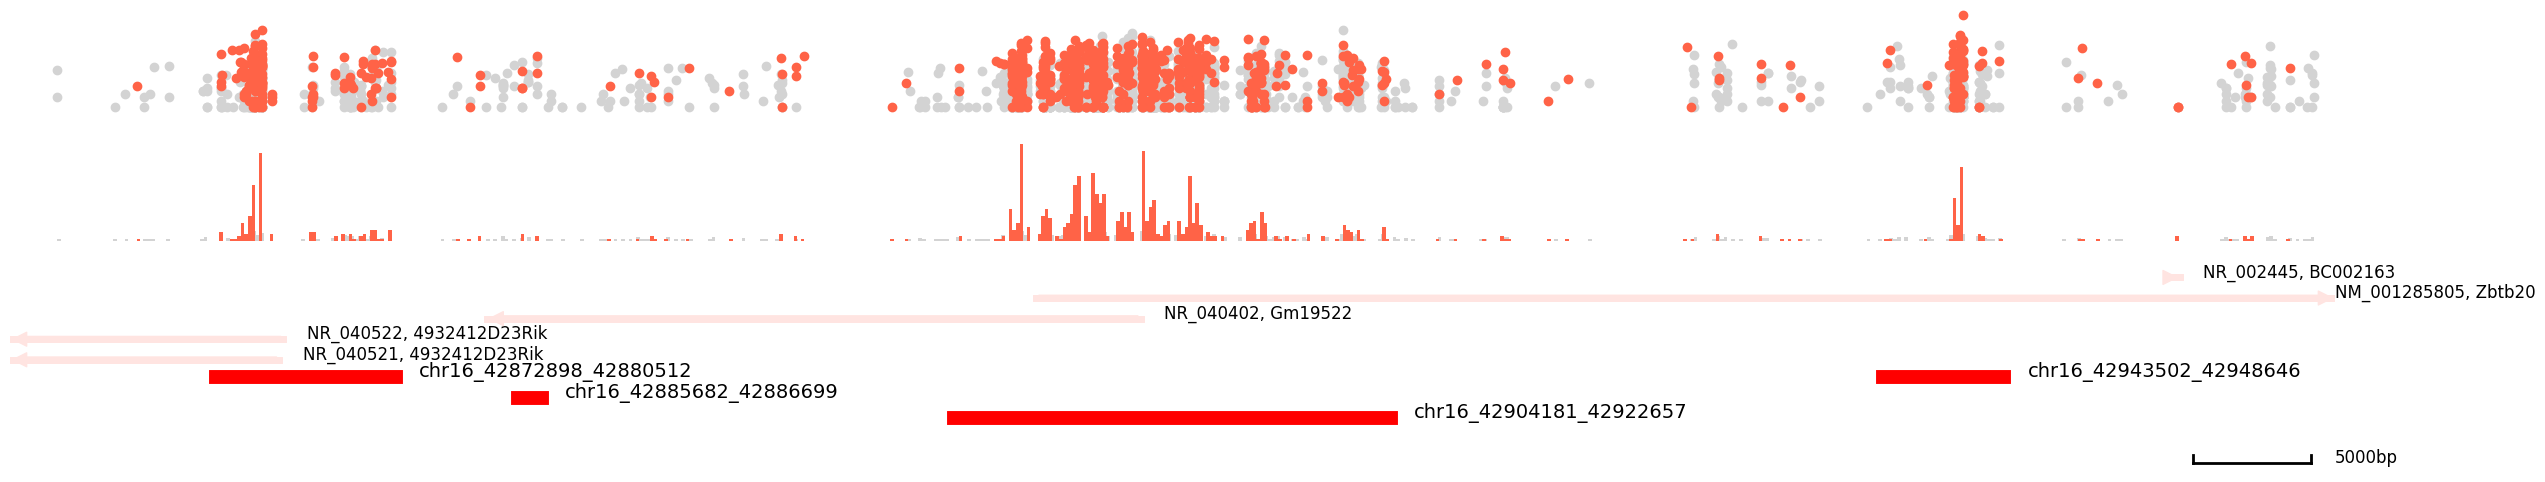

In [15]:
cc.pl.draw_area("chr16",42904181,42922657,40000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P10",key = "Index",insertionkey = "group", figsize = (30,6),peak_line = 3, bins = 600, example_length=5000,color = "purple")
cc.pl.draw_area("chr16",42904181,42922657,40000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P28",key = "Index", insertionkey = "group", figsize = (30,6),peak_line = 3,bins = 600,example_length=5000)

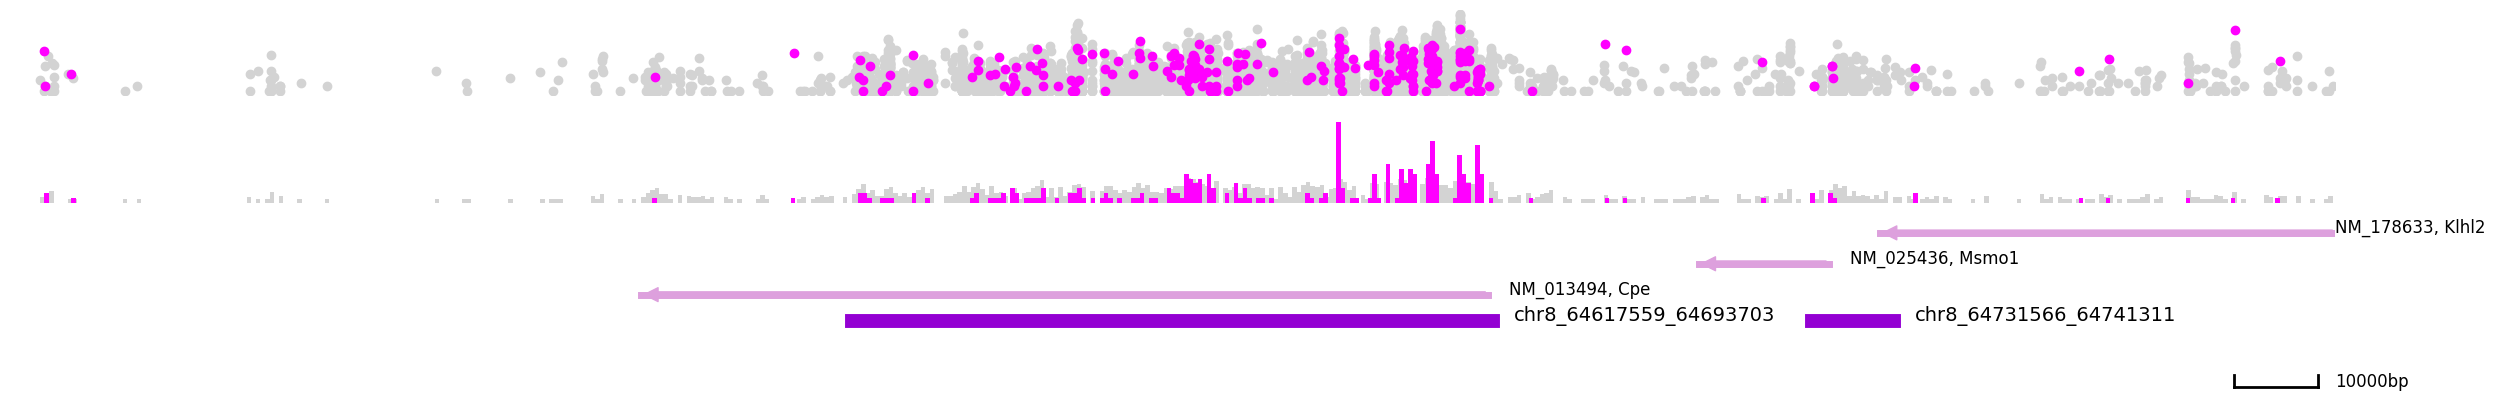

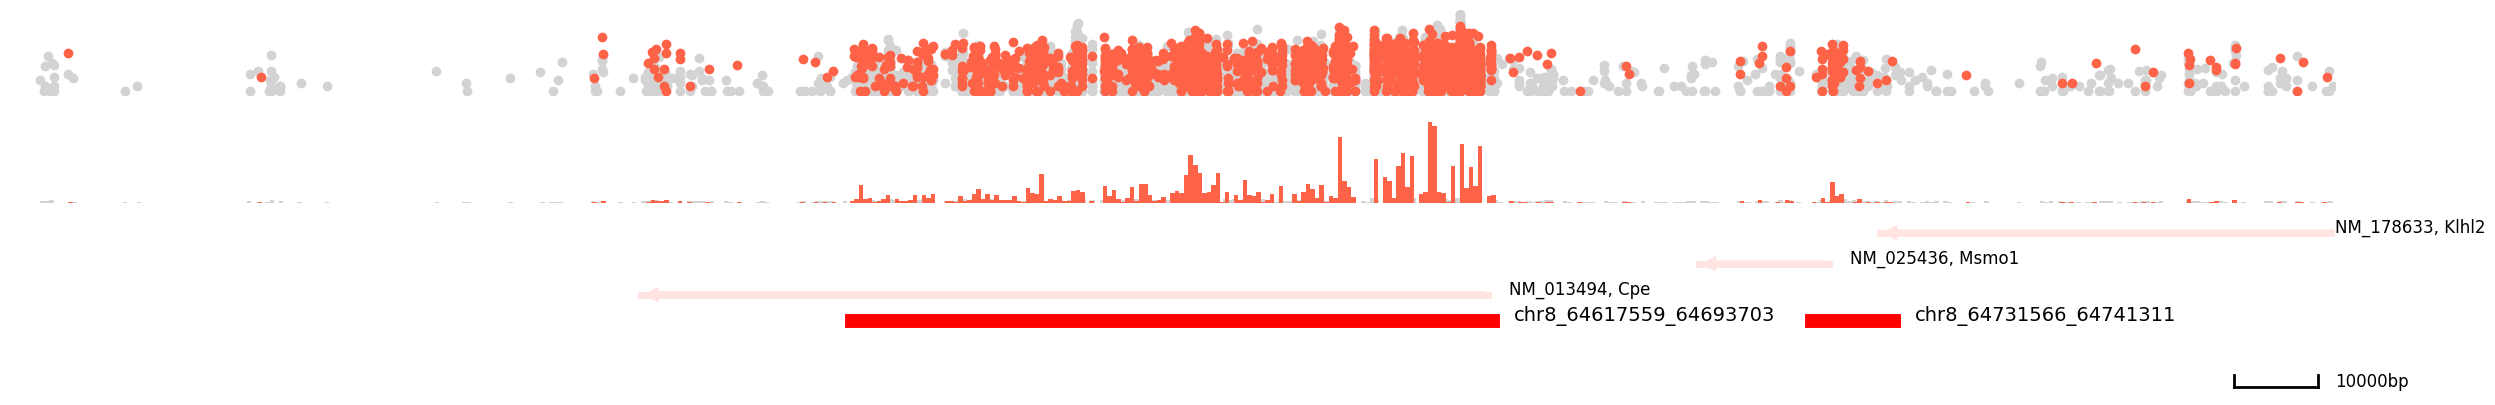

In [16]:
cc.pl.draw_area("chr8",64617559,64693703,100000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P10",key = "Index",insertionkey = "group", figsize = (30,5), bins = 500, peak_line = 1,color = "purple")
cc.pl.draw_area("chr8",64617559,64693703,100000, peak_data, SP1,"mm10",adata = adata_ccf, background = bg,
                name = "P28",key = "Index", insertionkey = "group", figsize = (30,5), bins = 500, peak_line = 1)

Plot the volcano plot for differential binding sites.

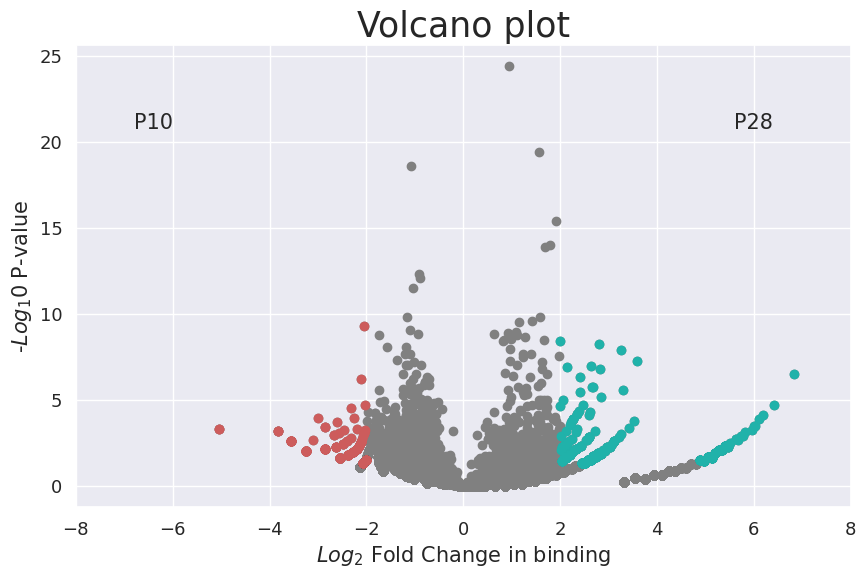

In [17]:
cc.pl.volcano_plot(adata_ccf, pvalue_cutoff = 0.05, lfc_cutoff = 2)

This is the heatmap for relative calling cards bindings.

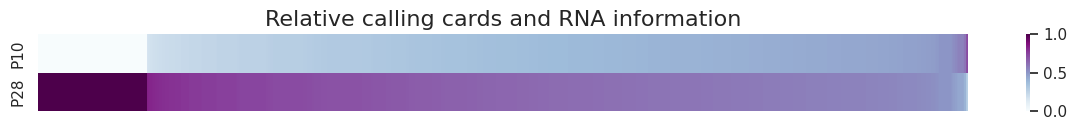

In [18]:
cc.pl.heatmap(adata_ccf, figsize=(15,1))

We could see from this plot that, P28 has lots of unique bindings and it has much more insertions for most of the peaks. This is consistent with the experiemnt as P28 is the accumulated insertions to Day 28 while P10 reflect the insertions until Day 10. 

Save the file if needed.

In [19]:
adata_ccf.write("SP1_CCF.h5ad")